# UAVSAR DOWNLOAD AND CONVERSION

###### By: Zachary Keskinen
###### Boise State University; Geophysics Department
###### ZachKeskinen@gmail.com
###### Created: 09/20/2021 Modified: 09/29/2021

This notebook downloads interferogram, amplitude, coherence, unwrapped phase, and (hopefully) incidence angle) of uavsar imgs from the vertex website and converts them to .tiff files. It will be converted to a function/class set at somepoint.

## Loading Libraries

In [1]:
import numpy as np # import libraries
import matplotlib.pyplot as plt
import re
import zipfile
import getpass
import os  # for chdir, getcwd, path.basename, path.exists
import pandas as pd # for DatetimeIndex
import codecs # for text parsing code
import netrc
import rasterio as rio
import glob
from osgeo import gdal
import io
import shutil
from subprocess import PIPE, Popen
import subprocess
import fcntl ##may need to pip install this one
import select
import sys
from snowexsql.snowexsql.conversions import INSAR_to_rasterio
from snowexsql.snowexsql.metadata import read_InSar_annotation
from snowexsql.snowexsql.projection import reproject_raster_by_epsg

## Hyperparameters

In [20]:
home_dir = '/SNOWDATA/uavsar/' #this needs to be a file path to the directory you want to save folders
url_dir = os.path.join(home_dir,'imgs' ,'urls','') #this should be a relative or full file path to where your urls are stored in txt or csv files
amp = True
inc = True
try:
    (ASF_USER, account, ASF_PASS) = netrc.netrc().authenticators("urs.earthdata.nasa.gov")
except:
    ASF_USER = input("Enter Username: ")
    ASF_PASS = getpass.getpass("Enter Password: ")

## Setting up File Structure

In [3]:
data_dir = home_dir + 'imgs/' #function might call this the out_dir
url_dir = data_dir + 'urls/'
os.makedirs(data_dir, exist_ok=True)

In [4]:
def downloading(file, directory):
    if os.path.exists(os.path.join(directory,os.path.basename(file))):
        ans = input(f'\nWARNING! You are about overwrite {os.path.basename(file)} previously '
                    f'converted UAVSAR Geotiffs files located at {directory}!\nPress Y to'
                    ' continue and any other key to abort: ')

        if ans.lower() == 'y':
            print(f'downloading {file}...')
            process = Popen(['wget',file,f'--user={ASF_USER}',f'--password={ASF_PASS}','-P',directory,'--progress=bar'], stderr=subprocess.PIPE)
            started = False
            for line in process.stderr:
                line = line.decode("utf-8", "replace")
                if started:
                    splited = line.split()
                    if len(splited) == 9:
                        percentage = splited[6]
                        speed = splited[7]
                        remaining = splited[8]
                        print("Downloaded {} with {} per second and {} left.".format(percentage, speed, remaining), end='\r')
                elif line == os.linesep:
                    started = True
        else:
            print('Skipping...')
    else:
        print(f'downloading {file}...')
        process = Popen(['wget',file,f'--user={ASF_USER}',f'--password={ASF_PASS}','-P',directory,'--progress=bar'], stderr=subprocess.PIPE)
        started = False
        for line in process.stderr:
            line = line.decode("utf-8", "replace")
            if started:
                splited = line.split()
                if len(splited) == 9:
                    percentage = splited[6]
                    speed = splited[7]
                    remaining = splited[8]
                    print("Downloaded {} with {} per second and {} left.".format(percentage, speed, remaining), end='\r')
            elif line == os.linesep:
                started = True

def img_dir_setup(file):
    ##Set up directory structure to hold this locations imgs and zips
    file_name = os.path.basename(file)
    loc_name = file_name.split('_')[0]
    loc_dir = os.path.join(data_dir, loc_name)
    os.makedirs(loc_dir, exist_ok = True)
    tmp_dir = os.path.join(loc_dir,'tmp')
    os.makedirs(tmp_dir, exist_ok = True)
    return tmp_dir, loc_dir

def unzip(in_dir, out_dir, suffix):
    for file in glob.glob(os.path.join(in_dir ,suffix)):
        if not os.path.exists(out_dir):
            os.makedirs(out_dir, exist_ok = True)
            with zipfile.ZipFile(file, "r") as zip_ref:
                print(f'Extracting {file} to {out_dir}')
                zip_ref.extractall(out_dir)
                print("done")

## Functions from Mikah's SNOWEXSQL Repo

In [49]:
"""
Convert UAVSAR data to geotiffs then reproject to UTM before uploading to db
Download from HP Marshalls Google Drive
Unzip to ~/Downloads
Otherwise see main() to redefine the location where the files are stored
"""

import glob
import shutil
import time
from os import listdir, mkdir
from os.path import abspath, basename, dirname, expanduser, isdir, join

from snowexsql.snowexsql.conversions import INSAR_to_rasterio
from snowexsql.snowexsql.metadata import read_InSar_annotation
from snowexsql.snowexsql.projection import reproject_raster_by_epsg
from snowexsql.snowexsql.utilities import get_logger, read_n_lines

log = get_logger('grd2tif')


def convert(filenames, output, epsg, clean_first=False, pol = False):
    """
    Convert all grd files from the UAVSAR grd to tiff. Then reporjects
    the resulting files from Lat long to UTM, and then saves to the output dir
    Args:
        filenames: List of *.grd files needed to be converted
        output: directory to output files to
        epsg: epsg of the resulting file
        clean_first: Boolean indicating whether to clear out the output folder first
    """
    # Keep track of errors, time elapsed, and number of files completed
    start = time.time()
    errors = []
    completed = 0

    # Clean up existing and make an output folder with a temp folder
    temp = join(output, 'temp')

    for d in [output, temp]:
        if isdir(d):
            if clean_first:
                log.info('Removing {}...'.format(d))
                shutil.rmtree(d)

        if not isdir(d):
            mkdir(d)

    nfiles = len(filenames)
    if nfiles > 0:
        log.info('Converting {} UAVSAR .grd files to geotiff...'.format(nfiles))

        directory = dirname(filenames[0])
        # Loop over all the files, name them using the same name just using a
        # different folder
        for ann in sorted(filenames):

            # open the ann file
            if pol:
                desc = read_PolSar_annotation(ann)
            else:
                desc = read_InSar_annotation(ann)
            
            # Form a pattern based on the annotation filename
            base_f = basename(ann)
            pattern = '.'.join(base_f.split('.')[0:-1]) + '*.grd'
            
            #save annotation data
            base = '_'.join(base_f.split('_')[0:5])
            desc_out = output +'/'+ base +'.csv'
            log.info('Saving data dict to {}'.format(desc_out))
            desc_dic = pd.DataFrame.from_dict(desc)
            desc_dic.to_csv(desc_out)
            
            # Gather all files associated
            grd_files = glob.glob(join(directory, pattern))
            grd_files = set(grd_files)

            log.info(
                'Converting {} grd files to geotiff...'.format(
                    len(grd_files)))

            for grd in grd_files:

                # Save to our temporary folder and only change fname to have
                # ext=tif
                latlon_tiff = grd.replace(directory, temp).replace('grd', 'tif')
                log.debug(f'Saving to {latlon_tiff}')
                try:
                    # Convert the GRD to a geotiff thats projected in lat long
                    INSAR_to_rasterio(grd, desc, latlon_tiff)
                    tiff_pattern = '.'.join(latlon_tiff.split('.')[0:-1]) + '*'
                    tif_files = glob.glob(tiff_pattern)

                    log.info(
                        'Reprojecting {} files to utm...'.format(
                            len(tif_files)))

                    for tif in glob.glob(tiff_pattern):
                        utm_file = tif.replace(temp, output)
                        reproject_raster_by_epsg(tif, utm_file, epsg)
                        completed += 1

                except Exception as e:
                    log.error(e)
                    errors.append((grd, e))

        nfiles = completed + len(errors)
        log.info('Converted {}/{} files.'.format(completed, nfiles))
        
        

    # Report errors an a convenient location for users
    if errors:
        log.warning(
            '{}/{} files errored out during conversion...'.format(len(errors), nfiles))
        for c in errors:
            f, e = c[0], c[1]
            log.error('Conversion of {} errored out with:\n{}'.format(f, e))

    # Clean up the temp folder
    log.debug('Removing {}...'.format(temp))
    shutil.rmtree(temp)

    log.info('Completed! {:0.0f}s elapsed'.format(time.time() - start))

## Downloading Zip Files and Extracting

In [50]:
def incidence_download(in_dir , out_dir):
    #extracts url to incidience angle for flight 1 and downloads incidience angle and ann file to new folder in out_dir
    for i in glob.glob(os.path.join(in_dir,'*.csv')):
        desc = pd.read_csv(i)
        site = os.path.basename(in_dir).split('_')[0]
        heading = os.path.basename(in_dir).split('_')[1]
        flight_id_1 = desc['flight id for pass 1'][0]
        flight_id_2 = desc['flight id for pass 2'][0]
        in_flight_count_1 = os.path.basename(in_dir).split('_')[2].split('-')[-1]
        in_flight_count_2 = os.path.basename(in_dir).split('_')[3].split('-')[-1]
        flight1_date = pd.to_datetime(desc['start time of acquisition for pass 1'][0]).strftime('%y%m%d')
        flight2_date = pd.to_datetime(desc['start time of acquisition for pass 2'][0]).strftime('%y%m%d')
        band_steering = os.path.basename(in_dir).split('_')[-3]
        if desc['cross talk removed'][0] == 'No':
            cross_talk = 'CX' #Should be XX but there doesn't seem to be no cross talk incidience angles?
        else:
            cross_talk = 'CX'
        processing_version = os.path.basename(in_dir).split('_')[-2]
        full_name = f'{site}_{heading}_{flight_id_1}_{in_flight_count_1}_{flight1_date}_{band_steering}_{cross_talk}_{processing_version}'
        file_inc = f'http://uavsar.asfdaac.alaska.edu/UA_{full_name}/{full_name}.inc'
        inc_dir = os.path.join(out_dir,full_name)
        downloading(file_inc, inc_dir)
        downloading(file_inc.replace('.inc','.ann'), inc_dir)
    return inc_dir


In [51]:
from snowexsql.snowexsql.data import SiteData
from snowexsql.snowexsql.db import get_table_attributes
from snowexsql.snowexsql.interpretation import *
from snowexsql.snowexsql.projection import add_geom, reproject_point_in_dict
from snowexsql.snowexsql.string_management import *
from snowexsql.snowexsql.utilities import assign_default_kwargs, get_logger, read_n_lines

def read_PolSar_annotation(ann_file): 
    with open(ann_file) as fp:
        lines = fp.readlines()
        fp.close()

        data = {}

        # loop through the data and parse
        for line in lines:

            # Filter out all comments and remove any line returns
            info = line.strip().split(';')
            comment = info[-1].strip().lower()
            info = info[0]

            # ignore empty strings
            if info and "=" in info:
                d = info.split('=')
                name, value = d[0], d[1]

                # Clean up tabs, spaces and line returns
                key = name.split('(')[0].strip().lower()
                units = get_encapsulated(name, '()')
                if not units:
                    units = None
                else:
                    units = units[0]

                value = value.strip()

                # Cast the values that can be to numbers ###
                if value.strip('-').replace('.', '').isnumeric():
                    if '.' in value:
                        value = float(value)
                    else:
                        value = int(value)

                # Assign each entry as a dictionary with value and units
                data[key] = {'value': value, 'units': units, 'comment': comment}

        # Convert times to datetimes
        for timing in ['start', 'stop']:
            key = '{} time of acquisition'.format(timing)
            dt = pd.to_datetime(data[key]['value'])
            dt = dt.astimezone(pytz.timezone('US/Mountain'))
            data[key]['value'] = dt

    return data

In [174]:
from rasterio.crs import CRS
from rasterio.transform import Affine
from snowexsql.snowexsql.projection import reproject_raster_by_epsg

# data_path = os.path.join(inc_dir, 'lowman_05208_21019_019_210316_L090_CX_01.inc')
# ann_path = os.path.join(inc_dir, 'lowman_05208_21019_019_210316_L090_CX_01.ann')
def convert_polsar(data_path, output, epsg):
    
    desc = read_PolSar_annotation(data_path.replace('.inc','.ann'))
    fname = os.path.basename(data_path).split('.')[1]

    # Grab the metadata for building our georeference
    nrow = desc[f'{fname}.set_rows']['value']
    ncol = desc[f'{fname}.set_cols']['value']

    # Find starting latitude, longitude already at the center
    lat1 = desc[f'{fname}.row_addr']['value']
    lon1 = desc[f'{fname}.col_addr']['value']

    # Delta latitude and longitude
    dlat = float(desc[f'{fname}.row_mult']['value'])
    dlon = float(desc[f'{fname}.col_mult']['value'])

    log.debug('Expecting data to be shaped {} x {}'.format(nrow, ncol))
    log.info('Using Deltas for lat/long = {} / {} degrees'.format(dlat, dlon))

    log.info('Reading {} and converting it from binary...'.format(basename(fname)))
    bytes = desc[f'{fname}.val_size']['value']

    dtype = np.dtype([('real', '<f{}'.format(bytes))])

    # Read in the data according to the annotation file and bytes
    z = np.fromfile(data_path, dtype)

    # Reshape it to match what the text file says the image is
    z = z.reshape(nrow, ncol)

    # Build the transform and CRS
    crs = CRS.from_user_input("EPSG:4326")
    
    # Lat1/lon1 are already the center so for geotiff were good to go.
    t = Affine.translation(lon1, lat1) * Affine.scale(dlon, dlat)
    #ext = output.split('.')[-1]
    fbase = os.path.basename(data_path) +'.tif'
    temp_dir = os.path.join(output, 'temp')
    os.makedirs(temp_dir, exist_ok=True)
    for i, comp in enumerate(['real', 'imaginary']):
        if comp in z.dtype.names:
            d = z[comp]
            out = os.path.join(temp_dir,fbase)
            log.info('Writing to {}...'.format(out))
            dataset = rio.open(
                out,
                'w+',
                driver='GTiff',
                height=d.shape[0],
                width=d.shape[1],
                count=1,
                dtype=d.dtype,
                crs=crs,
                transform=t,
            )
            # Write out the data
            dataset.write(d, 1)

            # show(new_dataset.read(1), vmax=0.1, vmin=-0.1)
            # for stat in ['min','max','mean','std']:
            #     log.info('{} {} = {}'.format(comp, stat, getattr(d, stat)()))
            dataset.close()
    
    
    reproject_raster_by_epsg(out, os.path.join(output, fname), epsg)
    


In [175]:
for loc in os.listdir(url_dir):
    urls = pd.read_csv(url_dir+loc, names = ['int_url'])
    for file in urls.int_url:
        if file == 'https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int_grd.zip':
            
            #set up file structure
            tmp_dir,loc_dir = img_dir_setup(file)
            
            #download int and amp zip files
            downloading(file, tmp_dir)
            if amp:
                downloading(file.replace('INTERFEROMETRY','AMPLITUDE').replace('int','amp'), tmp_dir)
            
            #unzip int and amp files
            grd_dir = os.path.join(tmp_dir, os.path.basename(file.replace('.zip','')))
            unzip(in_dir = tmp_dir, out_dir = grd_dir, suffix = '*int_grd.zip')    
            if amp:
                unzip(in_dir = tmp_dir, out_dir = grd_dir, suffix = '*amp_grd.zip')
            
            #convert to tiffs
            
            # Reprojection EPSG
            gm_epsg = 26912
            boi_epsg = 26911
            
            # Folder to output inside of location directory
            output = os.path.join(loc_dir , os.path.basename(grd_dir).replace('_grd',''))
            
            # Gather all .ann files
            filenames = glob.glob(join(grd_dir, '*.ann'))
            
            nfiles = len(filenames)
            
            if os.path.basename(loc_dir) == 'grmesa':
                epsg = gm_epsg
            else:
                epsg = boi_epsg
                
            if isdir(output):
                
                ans = input(f'\nWARNING! You are about overwrite {nfiles} previously '
                            f'converted UAVSAR Geotiffs files located at {output}!\nPress Y to'
                            ' continue and any other key to abort: ')

                if ans.lower() == 'y':
                    log.info(f'Converting {output}...')
                    convert(filenames, output, epsg)
                    log.info(f'Converted {output}...')

                else:
                    log.warning(
                        'Skipping conversion and overwriting of UAVSAR files...')
            else:
                mkdir(output)
                log.info(f'Converting {output}...')
                convert(filenames, output, epsg)
                log.info(f'Converted {output}...')
    
            if inc:
                inc_dir = incidence_download(in_dir = output, out_dir =tmp_dir)
                inc_filenames = glob.glob(join(inc_dir, '*.inc'))
                for inc_fp in inc_filenames:
                    convert_polsar(os.path.join(inc_dir,inc_fp), output, epsg)
                    
            
            
            


WARNING! You are about overwrite lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int_grd.zip previously converted UAVSAR Geotiffs files located at /SNOWDATA/uavsar/imgs/lowman/tmp!
Press Y to continue and any other key to abort: m
Skipping...

WARNING! You are about overwrite lowman_05208_21019-019_21021-007_0006d_s01_L090_01_amp_grd.zip previously converted UAVSAR Geotiffs files located at /SNOWDATA/uavsar/imgs/lowman/tmp!
Press Y to continue and any other key to abort: m
Skipping...

WARNING! You are about overwrite 4 previously converted UAVSAR Geotiffs files located at /SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int!
Press Y to continue and any other key to abort: m


grd2tif WARNING Skipping conversion and overwriting of UAVSAR files...



WARNING! You are about overwrite lowman_05208_21019_019_210316_L090_CX_01.inc previously converted UAVSAR Geotiffs files located at /SNOWDATA/uavsar/imgs/lowman/tmp/lowman_05208_21019_019_210316_L090_CX_01!
Press Y to continue and any other key to abort: m
Skipping...

WARNING! You are about overwrite lowman_05208_21019_019_210316_L090_CX_01.ann previously converted UAVSAR Geotiffs files located at /SNOWDATA/uavsar/imgs/lowman/tmp/lowman_05208_21019_019_210316_L090_CX_01!
Press Y to continue and any other key to abort: m


grd2tif DEBUG Expecting data to be shaped 16417 x 26688
grd2tif INFO Using Deltas for lat/long = -5.556e-05 / 5.556e-05 degrees
grd2tif INFO Reading inc and converting it from binary...


Skipping...


grd2tif INFO Writing to /SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int/temp/lowman_05208_21019_019_210316_L090_CX_01.inc.tif...


In [176]:
for fp in glob.glob(os.path.join(output ,'*.tif' )):
    #print(fp)
    #if fp == '/SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int/lowman_05208_21019-019_21021-007_0006d_s01_L090HH_01.amp2.real.tif':
        print(fp)
        inc_rast = rio.open(fp)
        meta_data = inc_rast.profile
        print(meta_data)

/SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int/lowman_05208_21019-019_21021-007_0006d_s01_L090HH_01.amp1.real.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 23940, 'height': 21603, 'count': 1, 'crs': CRS.from_epsg(26911), 'transform': Affine(5.023508574816554, 0.0, 553859.6221955194,
       0.0, -5.023508574816554, 4931021.2988628335), 'tiled': False, 'interleave': 'band'}
/SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int/lowman_05208_21019-019_21021-007_0006d_s01_L090HH_01.hgt.real.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 23940, 'height': 21603, 'count': 1, 'crs': CRS.from_epsg(26911), 'transform': Affine(5.023508574816554, 0.0, 553859.6221955194,
       0.0, -5.023508574816554, 4931021.2988628335), 'tiled': False, 'interleave': 'band'}
/SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int/lowman_05208_21019-019_21021-007_0006d_s01_L090

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 23940, 'height': 21603, 'count': 1, 'crs': CRS.from_epsg(26911), 'transform': Affine(5.023508574816554, 0.0, 553859.6221955194,
       0.0, -5.023508574816554, 4931021.2988628335), 'tiled': False, 'interleave': 'band'}
/SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int/lowman_05208_21019-019_21021-007_0006d_s01_L090VV_01.int.imaginary.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 23940, 'height': 21603, 'count': 1, 'crs': CRS.from_epsg(26911), 'transform': Affine(5.023508574816554, 0.0, 553859.6221955194,
       0.0, -5.023508574816554, 4931021.2988628335), 'tiled': False, 'interleave': 'band'}
/SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int/lowman_05208_21019-019_21021-007_0006d_s01_L090VV_01.amp1.real.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 23940, 'height': 21603, 'count': 1, 'crs': CRS.from_epsg(2691

In [189]:
a = rio.open('/SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int/lowman_05208_21019_019_210316_L090_CX_01.inc.tif').read(1)

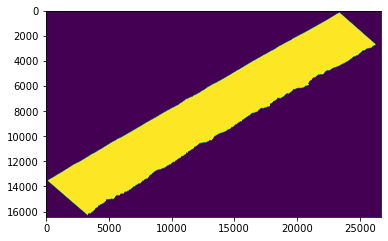

In [190]:
plt.imshow(a)

In [184]:
from rasterio import plot

TypeError: Invalid shape (438136895,) for image data

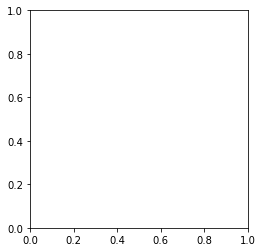

In [200]:
plot.show(b)

In [3]:
import rioxarray as rxr

In [11]:
inc_fp = '/SNOWDATA/uavsar/imgs/lowman/lowman_05208_21019-019_21021-007_0006d_s01_L090_01_int/lowman_05208_21019_019_210316_L090_CX_01.inc.tif'
a = rxr.open_rasterio(inc_fp)
a

<xarray.DataArray (band: 1, y: 16417, x: 26688)>
[438136896 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -116.3 -116.3 -116.3 ... -114.8 -114.8 -114.8
  * y            (y) float64 44.49 44.49 44.49 44.49 ... 43.57 43.57 43.57 43.57
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [19]:
# View the Coordinate Reference System (CRS) & spatial extent
print("The CRS for this data is:", a.rio.crs)
print("The spatial extent is:", a.rio.bounds())
# View no data value
print("The no data value is:", a.rio.nodata)

The CRS for this data is: EPSG:4326
The spatial extent is: (-116.32647204000001, 43.574541239999995, -114.84368676000003, 44.486669760000005)
The no data value is: None


(array([3.38476558e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.96603380e+07]),
 array([-1.0000000e+04, -8.9997969e+03, -7.9995938e+03, -6.9993906e+03,
        -5.9991880e+03, -4.9989849e+03, -3.9987817e+03, -2.9985786e+03,
        -1.9983756e+03, -9.9817249e+02,  2.0305610e+00], dtype=float32),
 <BarContainer object of 10 artists>)

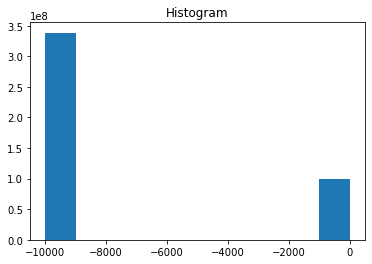

In [14]:
a.plot.hist()
plt.show()

In [10]:
print("the minimum raster value is: ", np.nanmin(a.values))
print("the maximum raster value is: ", np.nanmax(a.values))

the minimum raster value is:  -10000.0
the maximum raster value is:  2.030561


In [16]:
a = rxr.open_rasterio(inc_fp, masked=True).squeeze()

In [17]:
a.shape

(16417, 26688)

In [ ]:
b = a.rxr.write_nodata(-10000.0)
b.plot.hist()

In [22]:
print("The no data value is:", b.rio.nodata)

The no data value is: -10000.0


In [ ]:
b.plot()